# Simplicial Complex in Two Dimensions

We dsecribe the data structure of the simplicial complex associated to a
two dimensional trianglulation give by `node,elem` . The `node` records
the coordinates of vertices and `elem` is the pointer from local to
global incices of vertices. See [Basic mesh data structure](meshbasicdoc.html).

A brief summary.

- `edge`: asecond ordering, `i.e. edge(:,1)<edge(:,2)`

- `locEdge`: The default one is the consistent orientation which will be counter-clockwise if elem is positive ordered. The asecond orientation is used for edge elements.
  - consistent orientation `[2 3; 3 1; 1 2];`
  - asecond orientation    `[2 3; 1 3; 1 2];` 

- `elem`: positive ordering or ascend ordering. The default one is positive ordering and the asecond ordering is used for edge elements. 

- Use `[elem,bdFlag] = sortelem(elem,bdFlag)` to change the ordering to the ascend ordering. Note that `bdFlag` should be switched together.  

> The multigrid solvers use the original ordering of `elem` obtained from either uniform refinement or bisection methods. So let `elemold=elem` before sort.

- Examples on the usage: `PoissonRT0, PoissonBDM1`

## Outline

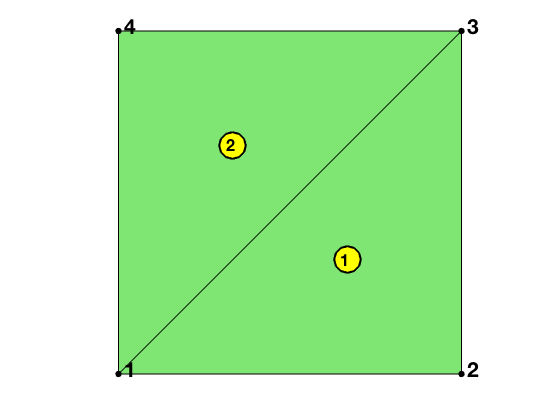

In [1]:
node = [0,0; 1,0; 1,1; 0,1];    % nodes
elem = [2,3,1; 4,1,3];          % elements
N = size(node,1); NT = size(elem,1); % NE = size(edge,1); 
showmesh(node,elem);
findelem(node,elem);
findnode(node);

The basic data structure of a mesh consists of node and elem:
In iFEM, `N, NE, NT` represents the muber of vertice, edges, triangles
respectively.

The corresponding simplicial complex consists of vertices, edges and
triangles. We shall discuss the following three issues:

- *Indexing* of simplexes
- *Ordering* of vertices of simplexes
- *Orientatoin* of simplexes

The indexing and ordering are related and the ordering and orientation
are mixed together. However the indexing has nothing to do with the
orientation. The indexing and ordering are the combinarotry structure,
i.e. only `elem` is needed, while the orientation also depends on `node`,
the geometry emembdding of vertices.

For indexing, ordering and orientation, there are always local and global versions. The relation between the local and global version is the most complicated issue.

## Indexing of Simplexes

The indexing refers to the numbering of simplexes, e.g., which edge is
numbered as the first one. There are two types of the indexing: local and
global. Each simplex in the simplicial complex has a unique index which
is called the global index. In one triangle, the three vertices and three
edges have their local index from 1:3. 

In the assembling procedure of finite element methods, an element-wise
matrix using the local indexing is first computed and then assembled to get a
big matrix using the global indexing. Thus the pointer from the local
indexing to the global indexing is indispensible. For bases independent of
the ordering and orientation, e.g., `P1` and `P2` elements, this pointer
is sufficient, otherwise, the inconsistency of the local ordering/orientation
and the global ordering/orientation should be taken into account.

### Indexing pointers of vertices

The `NT x 3` matrix `elem` is indeed the pointer from the local to the
global indices of vertices of triangles. For example `elem(t,1)=25` means
the first vertex of the triangle t is the 25-th vertex.

Similiary, the `NE x 2` matrix `edge` records the pointer from the local
to the global indices of vertices of edges.

### Local indexing of edges

The triangle constists of three vertices indexed as [1,2,3]. Each
triangle contains three edges. There are two indexing schemes for edges.

* Opposite indexing     `locEdge = [2,3; 3,1; 1,2]`

In `locEdge`, the `i-th` edge is opposite to the `i-th` verices and thus
called _opposite indexing_.

* Lexicogrphic indexing `locEdgel = [1,2; 1,3; 2,3]`

In `locEdgel`, the indexing is induced from the lexicographic ordering of
the three edges.

For 2-D triangulations, **we shall always chose opposite indexing**. The lexicographic indexing is mainly used in the construction of `face2edge` of 3-D triangulations; see [Simplicial Complex in Three
Dimensions](sc3doc.html). Note that the ordering of vertices of each edge will not change the indexing. For example, `locEdge = [2,3; 1,3; 1,2]` use the same opposite indexing but different ordering. Choosing `[1 3]` or `[3 1]` for the second edge will depend on the consideration of orientation and ordering.

### Global indexing of edges

One can easily collect all edges elementwise. The issue is the
duplication. For example, each interior edge will be counted twice. The
`unique` funciton is applied such that each edge has a unique global
index.

In [2]:
totalEdge = uint32([elem(:,[2,3]); elem(:,[3,1]); elem(:,[1,2])]);
sortedTotalEdge = sort(totalEdge,2);
[edge,tempvar,je] = unique(sortedTotalEdge,'rows');
NE = size(edge,1); 

### Edge pointer

`elem2edge(1:NT,1:3)` records the pointer from the local index to the
global index of edges. For example, `elem2edge(t,1)` = 10 means the first
edge of triangle `t` (which is formed by [2 3] vertices of `t`) is the
`10-th` one in the `edge` array.

Such information is stored in the third output of `unique` function.
`elem2edge = uint32(reshape(je,NT,3));`

Note that the pointer `elem2edge` depends on the local indexing of edges
used in the generation of `totalEdge`. Here the opposite indexing of
three local edges is used.

## Ordering of Vertices

We discuss the ordering of vertices of simplexes. Again there are local
ordering and global ordering. They may not be consistent and a sign array
is used to record the inconsistency.

The local ordering refers to the ordering of local veritces of a simplex.
The local ordering could be used in the formulation of the local basis
and thus the ordering does matter.

The global ordering refers to the ordering of the global index of
vertices of a simplex.

### elem
The local ordering is always [1,2,3]. Any permutation of three
veritces of a triangle still represents the same triangle. Such
freedom provide a room to record more information like:

* global ordering of vertices
* an orientation of triangles
* refinement rules

Two types of ordering of `elem` is of particular importance

* Positive ordering
* Ascend ordering

In the positive ordering, the three vertices are ordered such that the
signed area, det(v12,v13), is positive. If `elem` is not positive
ordered, `elem = fixorder(node,elem)` will compute the signed area by
`simplexvolume(node,elem)` and switch the vertices for triangles with
negative areas.

For 2-D triangulations, three vertices of a triangle in 2-D is sorted
counter-cloclwise and the first vertex is chosen as the newest vertex.
Such ordering enables the efficient implementation of local refinement
and coarsening in 2-D; see [Bisection in Two Dimensions](bisectdoc.html)
and [Coarsening in Two Dimensions](coarsendoc.html). **Such ordering scheme
is the default choice and used in most places**.


In ascend ordering, the vertices of `elem` is sorted such that

    elem(t,1)<elem(t,2)<elem(t,3)

This can be easily achieved by `elem = sort(elem,2)`. Howevery, one has to rotate the boundary flag
accordingly using `sortelem`.

In [3]:
bdFlag = setboundary(node,elem,'Dirichlet');
display('Before rotation'); display(elem); display(bdFlag);

[elem,bdFlag] = sortelem(elem,bdFlag);
display('After rotation'); display(elem); display(bdFlag);

Before rotation

elem =

     2     3     1
     4     1     3


bdFlag =

    0    1    1
    0    1    1

After rotation

elem =

     1     2     3
     1     3     4


bdFlag =

    1    0    1
    1    1    0



Ascend ordering will benefit the construction of local bases for high
order basis or basis with orientation.

We may switch the default positive ordering of `elem` to ascend ordering
when generating data structure for finite element basis. However such
sorting is always hidden in the subroutines when a finite element basis
requiring ordering is generated; see `PoissonRT0` and `PoissonBDM1`.


### edge

The global ordering of edges is always ascended, i.e.

    edge(:,1) < edge(:,2);

Indeed in the generation of `edge`, the `totalEdge` is sorted to the
ascend ordering such that `unique` can be applied to eliminate the duplication.

Recall that we always use the opposite indexing of edges. For the ordering

  - asecond ordering    `[2 3; 1 3; 1 2];` 
  - (orientation) consistent ordering `[2 3; 3 1; 1 2];`

It is consistent since the local ordering orientation of edges is
consistent with the induced orientation as the boundary of a triangle; see the
discussion on the orientation.

There might be an inconsistency between the local and global ordering
(even for the orientation consistent ordering). That is
`edge(elem2edge(t,1),1) > edge(elem2edge(t,1),2)` may happen. It will be more clear from the discussion of
the corresponding orientation.

## Orientation of Simplexes

The orientation of a triangle is either positive or negative. The
orientation of an edge is given by a tangential or normal vector. A
normal vector is obtained by rotate a given tangential vector by 90
degree clockwise. For example, when edges are given counter clockwise
orientation, the corresponding normal vector is the outwards normal
vector.

The orientation of a d-simplex will induce an orientation of its d-1
subcomplex on the boundary and is called _the induced orientation_. For example, a positive
orientated triangle will induce the counter clockwise orientation of its
three edges.

The ordering of vertices will naturally introduce an orientation and will
be called _the ordering-orientation_. More specifically

- The vector from `edge(:,1)` to `edge(:,2)` defines an orientation of
edges.
- The sign of `det(v12,v13)` defines an orientation of triangles.

The orientation of a simplex in the simplicial complex should be
uniquely determined which will be called _the global orientation_. It can be
chosen as the global ordering-orientation but not always the case.

Inside one triangle, the local orientation of three edges is more
involved. The local ordering of edges will introduce a local ordering
orientation. The orientation of the triangle will also induce an induced
orientation. The local ordering-orientation is used in the computation of
local bases and the induced orientation is used when computing the
differential operator locally. They may or may not be consisitent with
the global orientation of edges.

In general, there will be an inconsistency of the following types of
orientation and apporipate data structure should be constructured to
record such inconsistency.

* a global orientation
* the global ordering-orientation
* the local ordering-orientation
* the local induced orientation

### elem
The orientation of a triangle is either positive or negative. For
the global ordering-orientation, it is the sign of the signed area
(output of `simplexvolume`). 

    [Dlambda,area,elemSign] = gradbasis(node,elem);
    
In the output of `gradbasis`, `area` is always positive and an additional
array `elemSign` is used to record the sign of the signed area.

`Dlambda(t,:,k)` is the gradient of the barycentric coordinate $\lambda_k$. Therefore the outward normal direction of the kth face can be obtained by `-Dlambda(t,:,k)` which is independent of the ordering and orientation of triangle `t`.

### edge

For 2-D triangulations, **we shall always chose the global ordering
orientation**, i.e., from the lower index to the bigger index. 

The local ordering-orientation is implicitly used when computing finite
element basis in each element. For example, the edge element on edge `[i j]`
in `locEdge` is defined as

$$\phi_{i,j} = 2(\lambda_i \nabla \lambda_j - \lambda_j \nabla \lambda_i).$$ 

Permutation of `[i j]` to `[j i]` will change the sign of the basis. Note
that this is locally, i.e., element by element.

The global basis associated to this edge, however, depends only on its 
global orientation. We introduce `elem2edgeSign(1:NT, 1:3)`
to record the inconsistency of a local ordering-orientation and a global
orientation.

For the consistent local ordering [2 3; 3 1; 1 2] and the global ascend
ordering-orientation, the elem2edgeSign can be generated as follows:

    elem2edgeSign = ones(NT,3,'int8');
    totalEdge = uint32([elem(:,[2,3]); elem(:,[3,1]); elem(:,[1,2])]);
    idx = (totalEdge(:,1)>totalEdge(:,2));
    elem2edgeSign(idx) = -1;

There is one more inconsistency between the induced orientation and the
global orientation of edges. If a triangle is positive orientated, the
induced edge orientation should be given by the outwards (relative to a
triangle) normal vector. This induced orientation may not be consistent
with the global orientation of edges.

It depends on the ordering of `elem` and `locEdge`. When `elem` is
positive ordered and `locEdge` is consistently ordered, it is.

For the ascend ordering of `elem` and `edge`, we denote the direction as +1
if the direction of an edge is the same with the induced direction in a
certain elem, and -1 otherwise. Then the consistency is given by
`elem2edgeSign = [+1 -1 +1];`

The second sign is -1 because the local edge in the ascend ordering is `[1
3]` not `[3 1]`.

The `elem2edgeSign` will be used when assembling differential operators.
For example, when computing `div` operators on a positive orientated
triangle, the edge should have outwards normal direction or equivalently
the counter clockwise orientation.

We summarize the two popular ordering and orientation schemes below.

## Positive Ordering and Orientation

The vertice of the `eleme` is sorted such that the area is always
positive. i.e. the three vertices of the elem are ordered
counter-clockwisely. Furthermore the first vertex is always the newest
vertex of the triangle for the easy of local mesh refinement and
coarsening.

The local edge is using opposite indexing and consistent ordering

    locEdge = [2,3; 3,1; 1,2]

The ascend ordering is used for global edges, i.e., `edge` is sorted s.t.

     edge(:,1) < edge(:,2)

The inconsistency of the orientation is recorded in `elem2edgeSign`.

**This is the default ordering and orientation scheme.** 


## Ascend Ordering and Orientation

For H(curl) and H(div) elements and high order (cubic and above) H(grad) elements, we use the ascend Ordering and Orientation.

*Ascend ordering*. The vertices of `elem` is sorted such that

    elem(t,1)<elem(t,2)<elem(t,3)

The local edge is also in the ascend ordering

    locEdge = [2,3; 1,3; 1,2]

The ascend ordering is used for edges, i.e., `edge` is sorted s.t.

    edge(:,1) < edge(:,2)

It is easy to see the benefit of the ascend ordering: the ordering of local edges is consistent with the global ones and so is the corresponding orientation.

*Orientation*. We choose the ordering-orientation.

- elem: sign(det(v12,v13))
- edge: from the node with the smaller global index to the bigger one

For `edge`, the local and the global ordering-orientation is consistent. But they are not consistent with the induced orientation inside one triangle. Such inconsistency is recorded in 

    elem2edgeSign = [+1 -1 +1]

## An Example


elem =

     2     3     1
     4     1     3


edge =

           1           2
           1           3
           1           4
           2           3
           3           4


elem2edge =

           2           1           4
           2           5           3


elem2edgeSign =

    -1     1     1
     1     1    -1



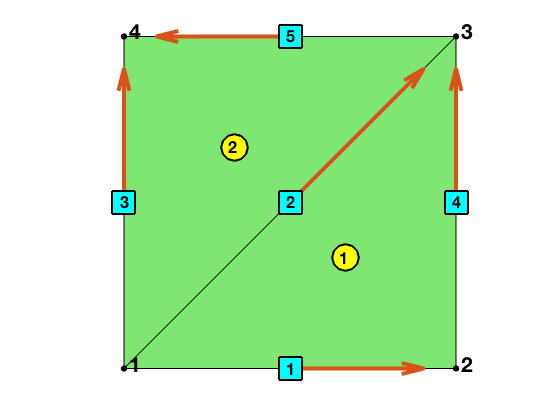

In [6]:
node = [0,0; 1,0; 1,1; 0,1];    % nodes
elem = [2,3,1; 4,1,3];          % elements

% Poistive ordering and orientation
[elem2edge,edge,elem2edgeSign] = dofedge(elem);
showmesh(node,elem);
findnode(node);
findelem(node,elem);
findedge(node,edge,'all','vec');
%%
display(elem);
display(edge);
display(elem2edge);
display(elem2edgeSign);


elem =

     1     2     3
     1     3     4


edge =

           1           2
           1           3
           1           4
           2           3
           3           4


elem2edge =

           4           2           1
           5           3           2


elem2edgeSign =

     1    -1     1
     1    -1     1



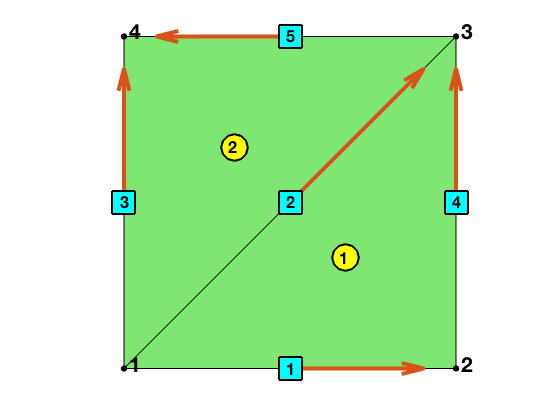

In [8]:
node = [0,0; 1,0; 1,1; 0,1];    % nodes
elem = [2,3,1; 4,1,3];          % elements

%%
% Ascend Ordering and Orientation
bdFlag = setboundary(node,elem,'Dirichlet');
[elem,bdFlag] = sortelem(elem,bdFlag);
[elem2edge,edge,elem2edgeSign] = dofedge(elem);
showmesh(node,elem);
findnode(node);
findelem(node,elem);
findedge(node,edge,'all','vec');
display(elem);
display(edge);
display(elem2edge);
display(elem2edgeSign);